# Vehicle Dynamics Simulator
**Contributors:** Shengfan Cao, Edward Zhu, Thomas Fork.

In [ ]:
%load_ext autoreload
%autoreload 2

# Install Dependencies

In [ ]:
if "dependencies_installed" not in globals():
    !git clone https://github.com/MPC-Berkeley/barc_gym.git --depth 1
    !pip install -r barc_gym/requirements.txt
    !pip install -e barc_gym/gym-carla
    !pip install -e barc_gym/mpclab_common
    !pip install -e barc_gym/mpclab_controllers
    !pip install -e barc_gym/mpclab_simulation
    dependencies_installed = True

Cloning into 'barc_gym'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 73 (delta 7), reused 47 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 94.97 KiB | 2.97 MiB/s, done.
Resolving deltas: 100% (7/7), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.5 MB/s eta 0:00:00
Obtaining file:///content/barc_gym/gym-carla
  Preparing metadata (setup.py) ... done
  Running setup.py develop for gym_carla
Obtaining file:///content/barc_gym/mpclab_common
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mpclab_common
Obtaining file:///content/barc_gym/mpclab_controllers
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mpclab_controllers
Obtaining file:///content/barc_gym/mpclab_simulation
  Preparing metadata (setup.py) ... done
  Running s

In [ ]:
import site
import warnings
site.main()
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
import numpy as np
import gymnasium as gym
import gym_carla
from matplotlib import pyplot as plt
from loguru import logger

# Part 0: Defining the base PID controller
**TODO: Reference Slides (slide 32) or the book (chapter 5.1) and lay out the formula. **

## Preliminary: Vehicle State definition

We follow the same vehicle state definition as the ROS messages we use in the hardware experiments. The following snippet shows the definition of fields that are the most relevant to your task.

```python
@dataclass
class Position(PythonMsg):
    x: float = field(default=0)
    y: float = field(default=0)
    z: float = field(default=0)
    ...

@dataclass
class BodyLinearVelocity(PythonMsg):
    v_long: float = field(default=0)
    v_tran: float = field(default=0)
    v_n: float = field(default=0)

@dataclass
class BodyAngularVelocity(PythonMsg):
    w_phi: float = field(default=0)
    w_theta: float = field(default=0)
    w_psi: float = field(default=0)

@dataclass
class OrientationEuler(PythonMsg):
    phi: float = field(default=0)
    theta: float = field(default=0)
    psi: float = field(default=0)

@dataclass
class ParametricPose(PythonMsg):
    s: float = field(default=0)
    x_tran: float = field(default=0)
    n: float = field(default=0)
    e_psi: float = field(default=0)

@dataclass
class VehicleActuation(PythonMsg):
    t: float        = field(default=0)
    u_a: float      = field(default=0)
    u_steer: float  = field(default=0)
    ...

@dataclass
class VehicleState(PythonMsg):
    '''
    Complete vehicle state (local, global, and input)
    '''
    t: float                        = field(default=None)  # time in seconds
    x: Position                     = field(default=None)  # global position
    v: BodyLinearVelocity           = field(default=None)  # body linear velocity
    w: BodyAngularVelocity          = field(default=None)  # body angular velocity
    e: OrientationEuler             = field(default=None)  # global orientation (phi, theta, psi)
    p: ParametricPose               = field(default=None)  # parametric position (s, y, ths)
    u: VehicleActuation             = field(default=None)  # control inputs (u_a, u_steer)
    lap_num: int = field(default=None)
    ...
```

Use the dot notation to access an attribute of the data structure above. For example, to access the global y coordinate given a state object `vehicle_state`, you should do `vehicle_state.x.y`.

## Defining the PID Parameters

In [ ]:
from mpclab_common.pytypes import PythonMsg
from dataclasses import dataclass, field


@dataclass
class PIDParams(PythonMsg):
    """
    This is a template for PID Parameters.
    Make sure you understand what each parameter means,
    but DON'T MODIFY ANYTHING HERE!
    """
    dt: float = field(default=0.1)  # The frequency of the controller
    Kp: float = field(default=2.0)  # The P component.
    Ki: float = field(default=0.0)  # The I component.
    Kd: float = field(default=0.0)  # The D component.

    # Constraints
    int_e_max: float = field(default=100)
    int_e_min: float = field(default=-100)
    u_max: float = field(default=None)
    u_min: float = field(default=None)
    du_max: float = field(default=None)
    du_min: float = field(default=None)

    # References
    u_ref: float = field(default=0.0)  # Input reference
    x_ref: float = field(default=0.0)  # PID state reference


## Implementing the base class for PID controller

**TODO:** Reference the slides or the book.

In [ ]:
from typing import Tuple

class PID():
    '''
    Base class for PID controller
    Meant to be packaged for use in actual controller (eg. ones that operate directly on vehicle state) since a PID controller by itself is not sufficient for vehicle control
    See PIDLaneFollower for a PID controller that is an actual controller
    '''
    def __init__(self, params: PIDParams = PIDParams()):
        self.dt             = params.dt

        self.Kp             = params.Kp             # proportional gain
        self.Ki             = params.Ki             # integral gain
        self.Kd             = params.Kd             # derivative gain

        # Integral action and control action saturation limits
        self.int_e_max      = params.int_e_max
        self.int_e_min      = params.int_e_min
        self.u_max          = params.u_max
        self.u_min          = params.u_min
        self.du_max         = params.du_max
        self.du_min         = params.du_min

        self.x_ref          = params.x_ref  # PID State reference
        self.u_ref          = params.u_ref  # Input reference
        self.u_prev         = 0             # Internal buffer for previous input

        self.e              = 0             # error
        self.de             = 0             # finite time error difference
        self.ei             = 0             # accumulated error

        self.initialized = True

    def solve(self, x: float,
                u_prev: float = None) -> Tuple[float, dict]:
        if not self.initialized:
            raise(RuntimeError('PID controller is not initialized, run PID.initialize() before calling PID.solve()'))

        if self.u_prev is None and u_prev is None: u_prev = 0
        elif u_prev is None: u_prev = self.u_prev

        info = {'success' : True}

        # Compute error terms
        e_t = x - self.x_ref
        de_t = (e_t - self.e)/self.dt
        ei_t = self.ei + e_t*self.dt

        # Anti-windup
        if ei_t > self.int_e_max:
            ei_t = self.int_e_max
        elif ei_t < self.int_e_min:
            ei_t = self.int_e_min

        # Compute control action terms
        P_val  = self.Kp * e_t
        I_val  = self.Ki * ei_t
        D_val  = self.Kd * de_t

        u = -(P_val + I_val + D_val) + self.u_ref

        # Compute change in control action from previous timestep
        du = u - u_prev

        # Saturate change in control action
        if self.du_max is not None:
            du = self._saturate_rel_high(du)
        if self.du_min is not None:
            du = self._saturate_rel_low(du)

        u = du + u_prev

        # Saturate absolute control action
        if self.u_max is not None:
            u = self._saturate_abs_high(u)
        if self.u_min is not None:
            u = self._saturate_abs_low(u)

        # Update error terms
        self.e  = e_t
        self.de = de_t
        self.ei = ei_t

        self.u_prev = u
        return u, info

    def set_x_ref(self, x_ref: float):
        self.x_ref = x_ref
        # reset error integrator
        self.ei = 0
        # reset error, otherwise de/dt will skyrocket
        self.e = 0

    def set_u_ref(self, u_ref: float):
        self.u_ref = u_ref

    def clear_errors(self):
        self.ei = 0
        self.de = 0

    def set_params(self, params:  PIDParams):
        self.dt             = params.dt

        self.Kp             = params.Kp             # proportional gain
        self.Ki             = params.Ki             # integral gain
        self.Kd             = params.Kd             # derivative gain

        # Integral action and control action saturation limits
        self.int_e_max      = params.int_e_max
        self.int_e_min      = params.int_e_min
        self.u_max          = params.u_max
        self.u_min          = params.u_min
        self.du_max         = params.du_max
        self.du_min         = params.du_min

    # Below are helper functions that might be helpful in debugging.
    def get_refs(self) -> Tuple[float, float]:
        return (self.x_ref, self.u_ref)

    def get_errors(self) -> Tuple[float, float, float]:
        return (self.e, self.de, self.ei)

    # Below are clipping functions to enforce hard constraints.
    def _saturate_abs_high(self, u: float) -> float:
        return np.minimum(u, self.u_max)

    def _saturate_abs_low(self, u: float) -> float:
        return np.maximum(u, self.u_min)

    def _saturate_rel_high(self, du: float) -> float:
        return np.minimum(du, self.du_max)

    def _saturate_rel_low(self, du: float) -> float:
        return np.maximum(du, self.du_min)


# Part 1: Implementing and tuning a PID lane follower
**TODO: Introductions. Example:**

In this implementation, we follow a simple idea to control the speed and steering control separately by designing two separate PID controllers.

Specifically, the speed control PID tries to follow a reference speed, while the steering control PID tries to minimize the lateral deviation from the reference path.

Note that this PID controller only follows the center line of the track at a constant velocity.
Later, we will implement a better controller that can follow a race line.

In [ ]:
from mpclab_controllers.abstract_controller import AbstractController
from mpclab_common.pytypes import VehicleState

class PIDLaneFollower(AbstractController):
    '''
    Class for PID throttle and steering control of a vehicle
    Incorporates separate PID controllers for maintaining a constant speed and a constant lane offset

    target speed: v_ref
    target lane offset_ x_ref
    '''
    def __init__(self, dt: float,
                steer_pid_params: PIDParams = None,
                speed_pid_params: PIDParams = None):
        if steer_pid_params is None:
            steer_pid_params = PIDParams()
            steer_pid_params.dt = dt
            steer_pid_params.default_steer_params()
        if speed_pid_params is None:
            speed_pid_params = PIDParams()
            speed_pid_params.dt = dt
            speed_pid_params.default_speed_params()  # these may use dt so it is updated first

        self.dt = dt
        steer_pid_params.dt = dt
        speed_pid_params.dt = dt

        self.steer_pid_params = steer_pid_params
        self.speed_pid_params = speed_pid_params

        self.steer_pid = PID(self.steer_pid_params)
        self.speed_pid = PID(self.speed_pid_params)

        self.lat_ref = steer_pid_params.x_ref
        self.steer_pid.set_x_ref(0)  # For simplicity, we will just follow the center line in this problem. DO NOT MODIFY!

        self.requires_env_state = False
        return

    def reset(self):
        # Reinstantiate the two PID controllers.
        self.steer_pid = PID(self.steer_pid_params)
        self.speed_pid = PID(self.speed_pid_params)

    def initialize(self, **args):
        return

    def solve(self, *args, **kwargs):
        raise NotImplementedError

    def step(self, vehicle_state: VehicleState, env_state = None):
        v = vehicle_state.v.v_long

        vehicle_state.u.u_a, _ = self.speed_pid.solve(v)

        # Weighting factor: alpha*x_trans + beta*psi_diff
        alpha = 5.0
        beta = 1.0
        vehicle_state.u.u_steer, _ = self.steer_pid.solve(alpha*(vehicle_state.p.x_tran - self.lat_ref) + beta*vehicle_state.p.e_psi)
        return np.array([vehicle_state.u.u_a, vehicle_state.u.u_steer])

    def get_prediction(self):
        return None

    def get_safe_set(self):
        return None

## Create an instance of your PID controller with the parameters

Initialize/Reset your controller.
If you decide to implement your own controller, it must have a step function with the following method signature:

```
def step(state: VehicleState) -> np.ndarray:
    ...
```

Also, make sure your controller also modify the action fields (`state.u.u_a` and `state.u.u_steer`) in place, so that it will work in the hardware experiments later.

In [ ]:
#@markdown ## Set PID parameters
#@markdown ### Steering PID Parameters
Kp_steer = 0.85 #@param {type:"slider", min:0.0, max:2.0, step:0.05}
Ki_steer = 0  #@param {type:"slider", min:0.0, max:2.0, step:0.05}
Kd_steer = 0.05  #@param {type:"slider", min:0.0, max:2.0, step:0.05}

#@markdown ### Speed PID Parameters
Kp_speed = 0.3 #@param {type:"slider", min:0.0, max:2.0, step:0.05}
Ki_speed = 0  #@param {type:"slider", min:0.0, max:2.0, step:0.05}
Kd_speed = 0  #@param {type:"slider", min:0.0, max:2.0, step:0.05}
reference_speed = 1.0  #@param

# Some other global parameters. Don't modify them!
seed = 42
dt = 0.1


In [ ]:
pid_steer_params = PIDParams(dt=dt,
                             Kp=Kp_steer, # Use the parameters from the sliders above.
                             Ki=Ki_steer,
                             Kd=Kd_steer,
                             u_max=0.436,
                             u_min=-0.436,
                             du_max=4.5,
                             du_min=-4.5,
                             x_ref=0.0,  # Offset from the center line. Set to 0 to follow the center line.
                             )

pid_speed_params = PIDParams(dt=dt,
                             Kp=Kp_speed,
                             Ki=Ki_speed,
                             Kd=Kd_speed,
                             u_max=2.0,
                             u_min=-2.0,
                             du_max=20.0,
                             du_min=-20.0,
                             x_ref=reference_speed,  # Reference speed.
                             )
pid_controller = PIDLaneFollower(dt, pid_steer_params, pid_speed_params)


## Simulate the controller
The environment is implemented following the standard definition of OpenAI gym.

**Explanation of the parameters:**
- `truncated` indicates whether it is at a terminal state (collision with the boundary, going too slow (slower than 0.25 m/s), going in the wrong way, or finished the requested number of laps)
- `terminated` indicates whether the car just finished a lap.
- `info` is a dictionary that contains the ground truth vehicle_state and other helpful debugging information.


In [ ]:
# Create an instance of the simulator.
env = gym.make('barc-v0',
               track_name='L_track_barc',
               do_render=True,
               max_n_laps=2,  # Feel free to modify this.
               in_colab=True,
               )
env.unwrapped.bind_controller(pid_controller)

# Reset the car to the starting line, with an initial velocity of 0.5 m/s.
_, info = env.reset(seed=seed, options={'spawning': 'fixed'})

truncated = False # Flag indicating whether the car is at a terminal state.

# Reset the PID controller (clear the errors).
pid_controller.reset()

lap_time = []  # Keep track of the lap times.

while not truncated:
    action = pid_controller.step(vehicle_state=info['vehicle_state']) # Call the controller to get the steering and speed commands.
    _, _, terminated, truncated, info = env.step(action) # Apply the action on the car and get the updated state.

    if terminated:
        lap_time.append(info['lap_time'])  # Keep track of the time it took to finish a lap.

logger.info(f"Average lap time: {np.mean(lap_time):.1f} s. Std: {np.std(lap_time):.1f} s.")
logger.info("Rollout truncated.")

2025-04-22 22:16:25.310 | DEBUG    | gym_carla.envs.barc.barc_env:reset:181 - Respawning at fixed location.
2025-04-22 22:16:33.717 | INFO     | gym_carla.envs.barc.barc_env:step:258 - Lap 0 finished in 19.8 s. avg_v = 0.8974, max_v = 0.9836, min_v = 0.5000
2025-04-22 22:16:40.149 | INFO     | gym_carla.envs.barc.barc_env:step:258 - Lap 1 finished in 18.3 s. avg_v = 0.9733, max_v = 0.9895, min_v = 0.9358
2025-04-22 22:16:40.181 | INFO     | __main__:<cell line: 0>:27 - Average lap time: 19.1 s. Std: 0.8 s.
2025-04-22 22:16:40.185 | INFO     | __main__:<cell line: 0>:28 - Rollout truncated.


## Playback of the race
This cell generates a matplotlib figure of the trajectory and statistics of the race that is just simulated.
Use this to debug and tune your controller!

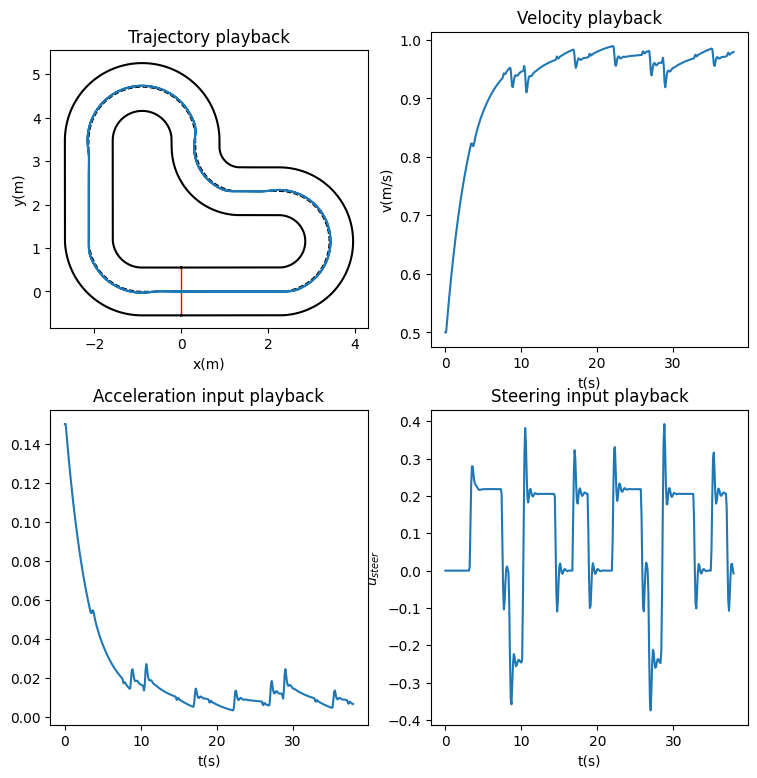

In [ ]:
env.unwrapped.show_debug_plot()

## Animation (Optional)
Render an animation of the race.

Note that this may take a long time (about 4 frames per second). (FYI the simulation runs at 10 frames per second)

The playback speed is **2x compared to real time.**

In [ ]:
render_animation = False  #@param {type:"boolean"}

In [ ]:
if render_animation:
    from IPython.display import HTML
    animation = env.unwrapped.visualizer.get_animation()
    print(f"Please wait for the animation to be rendered. Estimated total wait time: {len(env.unwrapped.v_buffer) * 0.25:.1f} s. ")
    display(HTML(animation.to_html5_video()))

## Compare with hardware data (Optional)
**Warning:** Upload the csv file converted from the ROS bag that is generated on your hardware test first!

Replace TODO with your group name. Your csv file should have the same name.

In [ ]:
compare_with_hardware_data = False  #@param {type:"boolean"}
group_name = "group_1" #@param {type:"string"}


In [ ]:
if compare_with_hardware_data:
    import pandas as pd
    from google.colab import files
    import os

    while not os.path.exists(f'{group_name}.csv'):
        print(f"Data file {group_name}.csv not found. Please upload it here.")
        uploaded = files.upload()
    df = pd.read_csv(f'{group_name}.csv', delimiter=',')
    # df = pd.read_csv(f'{group_name}.csv', delimiter=',')

    fig, axes = plt.subplots(2, 2, figsize=(9, 9))
    ((ax_traj, ax_v), (ax_u_a, ax_u_steer)) = axes
    start_idx = np.where((df['u_a'] != 0) & (df['u_steer'] != 0) & (df['v_long'] >= 0.5))[0][0]
    t = df['t'][start_idx:]
    t = (t - t.min()) / 1e9

    env.unwrapped.get_track().plot_map(ax=ax_traj)
    ax_traj.plot(df['x'][start_idx:], df['y'][start_idx:], label='hardware')
    ax_traj.set_title("Trajectory Playback")
    ax_traj.set_xlabel('x(m)')
    ax_traj.set_ylabel('y(m)')

    ax_v.plot(t, df['v_long'][start_idx:], label='hardware')
    ax_v.set_title("Velocity playback")
    ax_v.set_xlabel('t(s)')
    ax_v.set_ylabel('v(m/s)')

    ax_u_a.plot(t, df['u_a'][start_idx:], label='hardware')
    ax_u_a.set_title("Acceleration input playback")
    ax_u_a.set_xlabel('t(s)')
    ax_u_a.set_ylabel('$u_a$')

    ax_u_steer.plot(t, df['u_steer'][start_idx:], label='hardware')
    ax_u_steer.set_title('Steering input playback')
    ax_u_steer.set_xlabel('t(s)')
    ax_u_steer.set_ylabel('$u_{steer}$')

    env.unwrapped.show_debug_plot(axes)

    for ax in axes.flatten():
        ax.legend()

    plt.show()

# Part 2: Raceline Tracking experiment

**TODO:**Introduction.

Example: Now we redesign the PID controller to track any reference, so that it can follow the raceline we derived and go in high speed.

In [ ]:
%%writefile my_script.py
from mpclab_controllers.abstract_controller import AbstractController
from mpclab_common.pytypes import VehicleState

class PIDRacelineFollower(AbstractController):
    '''
    Class for PID throttle and steering control of a vehicle
    Incorporates separate PID controllers for maintaining a constant speed and a constant lane offset

    target speed: v_ref
    target lane offset_ x_ref
    '''
    def __init__(self, dt: float,
                steer_pid_params: PIDParams = None,
                speed_pid_params: PIDParams = None):
        if steer_pid_params is None:
            steer_pid_params = PIDParams()
            steer_pid_params.dt = dt
            steer_pid_params.default_steer_params()
        if speed_pid_params is None:
            speed_pid_params = PIDParams()
            speed_pid_params.dt = dt
            speed_pid_params.default_speed_params()  # these may use dt so it is updated first

        self.dt = dt
        steer_pid_params.dt = dt
        speed_pid_params.dt = dt

        self.steer_pid_params = steer_pid_params
        self.speed_pid_params = speed_pid_params

        self.steer_pid_params.x_ref = 0  # TODO: This is temporary. Properly implement this.
        self.speed_pid_params.x_ref = 0  # TODO: This is temporary. Properly implement this.

        self.steer_pid = PID(self.steer_pid_params)
        self.speed_pid = PID(self.speed_pid_params)

        self.lat_ref = steer_pid_params.x_ref

        self.requires_env_state = False
        return

    def reset(self):
        # Reinstantiate the two PID controllers.
        self.steer_pid = PID(self.steer_pid_params)
        self.speed_pid = PID(self.speed_pid_params)

    def initialize(self, **args):
        return

    def solve(self, *args, **kwargs):
        raise NotImplementedError

    def step(self, vehicle_state: VehicleState, reference=None):
        # """
        # Reference solution (needs more test to get it to work):

        v_ref, x_tran_ref, psi_ref = reference['x0'], reference['x5'], reference['x3']
        u0_ref, u1_ref = reference['u0'], reference['u1']

        v = vehicle_state.v.v_long
        vehicle_state.u.u_a, _ = self.speed_pid.solve(v - v_ref)

        # Weighting factor: alpha*x_trans + beta*psi_diff
        alpha = 5.0
        beta = 1.0
        vehicle_state.u.u_steer, _ = self.steer_pid.solve(alpha*(vehicle_state.p.x_tran - x_tran_ref) + beta* (vehicle_state.p.e_psi - psi_ref))
        return np.array([vehicle_state.u.u_a, vehicle_state.u.u_steer])
        # """
        raise NotImplementedError
        # ============YOUR CODE HERE===============
        vehicle_state.u.u_a = TODO
        vehicle_state.u.u_steer = TODO
        # ============END YOUR CODE================
        return np.array([vehicle_state.u.u_a, vehicle_state.u_steer])

    def get_prediction(self):
        return None

    def get_safe_set(self):
        return None

Overwriting my_script.py


In [ ]:
from google.colab import files
files.download('my_script.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import os
from google.colab import files


class Raceline:
    def __init__(self, raceline_file='raceline.npz'):
        while not os.path.exists(raceline_file):
            print(f"Raceline data file {raceline_file} is not found. Please upload it here. ")
            uploaded = files.upload()
        data = np.load(raceline_file)
        self.s, self.ey, self.epsi, self.vx, self.vy, self.epsi_dot, self.t, self.u0, self.u1 = map(np.array, (data['s'], data['e_y'], data['e_psi'], data['v_long'], data['v_tran'], data['psidot'], data['t'], data['u_a'], data['u_s']))

    def get_reference(self, _s, speed_scaling=1.):
        # interp = lambda yp: np.interp(_s, self.s, yp)
        # ey_ref, epsi_ref, vx_ref, vy_ref, epsi_dot_ref, t_ref, u0_ref, u1_ref = map(interp, (self.ey, self.epsi, self.vx, self.vy, self.epsi_dot, self.t, self.u0, self.u1))

        ey_ref = np.interp(_s, self.s, self.ey)
        epsi_ref = np.interp(_s, self.s, self.epsi)
        vx_ref = np.interp(_s, self.s, self.vx) * speed_scaling  # TODO: This is just a trick to scale down the speed to make the raceline easier to track. PROPERLY IMPLEMENT THIS!
        vy_ref = np.interp(_s, self.s, self.vy)
        epsi_dot_ref = np.interp(_s, self.s, self.epsi_dot)
        t_ref = np.interp(_s, self.s, self.t)
        u0_ref = np.interp(_s, self.s, self.u0)
        u1_ref = np.interp(_s, self.s, self.u1)
        return {
            's': _s,
            'x0': vx_ref,
            'x1': vy_ref,
            'x2': epsi_dot_ref,
            'x3': epsi_ref,
            'x4': t_ref,
            'x5': ey_ref,
            'u0': u0_ref,
            'u1': u1_ref,
        }

    def plot_raceline(self, ax):
        svec = self.s
        Psi = self.epsi[0]
        X, Y = [0], [self.ey[0]]
        for j in range(1,len(svec)):
            sj = svec[j]
            deltaT = self.t[j] - self.t[j-1]
            Psi = Psi + deltaT * self.epsi_dot[j]
            X.append(X[j-1] + deltaT * (self.vx[j] * np.cos(Psi) - self.vy[j] * np.sin(Psi)))
            Y.append(Y[j-1] + deltaT * (self.vx[j] * np.sin(Psi) + self.vy[j] * np.cos(Psi)))
        ax.plot(X, Y, c='r', ls='--', label='raceline')

Raceline().get_reference(1)  # TODO: Remove this debugging command.

Raceline data file raceline.npz is not found. Please upload it here. 


Raceline data file raceline.npz is not found. Please upload it here. 


KeyboardInterrupt: 

In [ ]:
%%writefile config.py
#@markdown ## Set PID parameters
#@markdown ### Steering PID Parameters
Kp_steer = 0.25 #@param {type:"slider", min:0.0, max:2.0, step:0.05}
Ki_steer = 0.1  #@param {type:"slider", min:0.0, max:2.0, step:0.05}
Kd_steer = 0.05  #@param {type:"slider", min:0.0, max:2.0, step:0.05}

#@markdown ### Speed PID Parameters
Kp_speed = 0.3 #@param {type:"slider", min:0.0, max:2.0, step:0.05}
Ki_speed = 0  #@param {type:"slider", min:0.0, max:2.0, step:0.05}
Kd_speed = 0  #@param {type:"slider", min:0.0, max:2.0, step:0.05}

# Some other global parameters. Don't modify them!
seed = 42
dt = 0.1

In [ ]:
pid_steer_params_raceline_follower = PIDParams(dt=dt,
                             Kp=Kp_steer, # Use the parameters from the sliders above.
                             Ki=Ki_steer,
                             Kd=Kd_steer,
                             u_max=0.436,
                             u_min=-0.436,
                             du_max=4.5,
                             du_min=-4.5,
                             x_ref=0.0,  # Offset from the center line. Set to 0 to follow the center line.
                             )

pid_speed_params_raceline_follower = PIDParams(dt=dt,
                             Kp=Kp_speed,
                             Ki=Ki_speed,
                             Kd=Kd_speed,
                             u_max=2.0,
                             u_min=-2.0,
                             du_max=20.0,
                             du_min=-20.0,
                             x_ref=reference_speed,  # Reference speed.
                             )
pid_controller = PIDLaneFollower(dt, pid_steer_params, pid_speed_params)


In [ ]:
# Create an instance of the simulator.
path_follower = PIDRacelineFollower(dt=dt, steer_pid_params=pid_steer_params_raceline_follower, speed_pid_params=pid_speed_params_raceline_follower)
raceline = Raceline()

env = gym.make('barc-v0',
               track_name='L_track_barc',
               do_render=True,
               max_n_laps=50,  # Feel free to modify this.
               in_colab=True,
               )
env.unwrapped.bind_controller(path_follower)

# Reset the car to the starting line, with an initial velocity of 0.5 m/s.
_, info = env.reset(seed=seed, options={'spawning': 'fixed'})

truncated = False # Flag indicating whether the car is at a terminal state.

# Reset the PID controller (clear the errors).
path_follower.reset()

lap_time = []  # Keep track of the lap times.

while not truncated:
    reference = raceline.get_reference(info['vehicle_state'].p.s, speed_scaling=0.7)
    action = path_follower.step(vehicle_state=info['vehicle_state'], reference=reference) # Call the controller to get the steering and speed commands.
    _, _, terminated, truncated, info = env.step(action) # Apply the action on the car and get the updated state.
    if terminated:
        lap_time.append(info['lap_time'])  # Keep track of the time it took to finish a lap.

logger.info(f"Average lap time: {np.mean(lap_time):.1f} s. Std: {np.std(lap_time):.1f} s.")
logger.info("Rollout truncated.")

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
env.unwrapped.show_debug_plot(axes)
raceline.plot_raceline(ax=axes[0][0])
for ax in axes.flatten():
    ax.legend()
plt.show()

## Compute a new raceline (Optional)

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
#   !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
# Original code at: https://github.com/MPC-Berkeley/barc_gym/blob/main/mpclab_common/mpclab_common/tracks/solve_raceline.py

import numpy as np
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd

from mpclab_common.pytypes import BodyAngularVelocity, BodyLinearVelocity, ParametricPose, VehicleState, VehicleActuation
# from mpclab_common.track import get_track

def compute_raceline(track, vehicle_config, vehicle_constraints,
                     obj_num=0,
                     raceline_to_avoid=None,
                     track_tightening=0,
                     constant_width=False):

    #SYSTEM STATES:  vx=x[0],  vy=x[1], wz=x[2] ,e_psi=x[3], t=x[4], e_y=x[5]
    #SYSTEM INPUTS:  ax[m/s^2]=u0, steering(rad)=u1
    #INDEPENDENT VARIABLE IS s (space)

    lf = vehicle_config.wheel_dist_front
    lr = vehicle_config.wheel_dist_rear

    mass = vehicle_config.mass
    Iz = vehicle_config.yaw_inertia

    tire_model = vehicle_config.tire_model

    mu = vehicle_config.wheel_friction
    Br = vehicle_config.pacejka_b_rear
    Bf = vehicle_config.pacejka_b_front
    Cr = vehicle_config.pacejka_c_rear
    Cf = vehicle_config.pacejka_c_front
    Dr = vehicle_config.pacejka_d_rear
    Df = vehicle_config.pacejka_d_front

    xu_ub = vehicle_constraints['xu_ub']
    xu_lb = vehicle_constraints['xu_lb']
    du_ub = vehicle_constraints['du_ub']
    du_lb = vehicle_constraints['du_lb']

    v_long_max = xu_ub.v.v_long
    v_long_min = xu_lb.v.v_long
    v_tran_max = xu_ub.v.v_tran
    v_tran_min = xu_lb.v.v_tran
    psidot_max = xu_ub.w.w_psi
    psidot_min = xu_lb.w.w_psi
    e_psi_max = xu_ub.p.e_psi
    e_psi_min = xu_lb.p.e_psi
    if constant_width:
        e_y_max = track.half_width - track_tightening
        e_y_min = -(track.half_width - track_tightening)
    else:
        # e_y_max = xu_ub.p.x_tran
        # e_y_min = xu_lb.p.x_tran
        e_y_max = 1e9
        e_y_min = -1e9

    a_max = xu_ub.u.u_a
    a_min = xu_lb.u.u_a
    steer_max = xu_ub.u.u_steer
    steer_min = xu_lb.u.u_steer

    a_rate_max = du_ub.u_a
    a_rate_min = du_lb.u_a
    steer_rate_max = du_ub.u_steer
    steer_rate_min = du_lb.u_steer

    print('=================== Raceline computation ===================')
    if track.circuit:
        print('Track is a circuit')
    else:
        print('Track is not a circuit')
    if constant_width:
        print('Using constant width')
    else:
        print('Using varying width')
    # print('Track name: %s' % track_name)
    # print('     - length: %g m' % track.track_length)
    # print('     - avg width: %g m' % (track.half_width*2))
    print('Vehicle configuration:')
    print('     - center of mass to front axle: %g m' % lf)
    print('     - center of mass to rear axle: %g m' % lr)
    print('     - mass: %g kg' % mass)
    print('     - yaw inertia: %g kg m^2' % Iz)
    print('     - tire model: %s' % tire_model)
    print('     - tire friction coefficient: %g' % mu)
    print('     - Front tires:')
    print('         - B: %g' % Bf)
    print('         - C: %g' % Cf)
    print('         - D: %g' % Df)
    print('     - Rear tires:')
    print('         - B: %g' % Br)
    print('         - C: %g' % Cr)
    print('         - D: %g' % Dr)
    print('Vehicle input constraints:')
    print('     - max acceleration: %g m/s^2' % a_max)
    print('     - min acceleration: %g m/s^2' % a_min)
    print('     - max steering angle: %g rad' % steer_max)
    print('     - min steering angle: %g rad' % steer_min)
    print('Vehicle state constraints:')
    print('     - max longitudinal velocity: %g m/s' % v_long_max)
    print('     - min longitudinal velocity: %g m/s' % v_long_min)
    print('     - max lateral velocity: %g m/s' % v_tran_max)
    print('     - min lateral velocity: %g m/s' % v_tran_min)
    print('     - max yaw rate: %g rad/s' % psidot_max)
    print('     - min yaw rate: %g rad/s' % psidot_min)
    print('============================================================')

    m = ConcreteModel()
    m.sf = Param(initialize=track.track_length)
    m.s = ContinuousSet(bounds=(0, m.sf))

    m.alpha_f   = Var(m.s, initialize=0)
    m.alpha_r   = Var(m.s, initialize=0)
    m.Fyf       = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.Fyr       = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.x0        = Var(m.s, bounds=(v_long_min, v_long_max), initialize=v_long_min)
    m.x1        = Var(m.s, bounds=(v_tran_min, v_tran_max), initialize=0)
    m.x2        = Var(m.s, bounds=(psidot_min, psidot_max), initialize=0)
    m.x3        = Var(m.s, bounds=(e_psi_min, e_psi_max))
    m.x4        = Var(m.s, bounds=(0, 20000), initialize=0)
    m.x5        = Var(m.s, bounds=(e_y_min, e_y_max), initialize=0)
    m.u0        = Var(m.s, bounds=(a_min, a_max), initialize=0)
    m.u1        = Var(m.s, bounds=(steer_min, steer_max), initialize=0)
    m.du0       = Var(m.s, bounds=(a_rate_min, a_rate_max), initialize=0)
    # m.du0       = Var(m.s, initialize=0)
    m.du1       = Var(m.s, bounds=(steer_rate_min, steer_rate_max), initialize=0)
    # m.du1       = Var(m.s, initialize=0)

    m.dx0ds = DerivativeVar(m.x0, wrt=m.s)
    m.dx1ds = DerivativeVar(m.x1, wrt=m.s)
    m.dx2ds = DerivativeVar(m.x2, wrt=m.s)
    m.dx3ds = DerivativeVar(m.x3, wrt=m.s)
    m.dx4ds = DerivativeVar(m.x4, wrt=m.s)
    m.dx5ds = DerivativeVar(m.x5, wrt=m.s)
    m.du0ds = DerivativeVar(m.u0, wrt=m.s)
    m.du1ds = DerivativeVar(m.u1, wrt=m.s)

    # to avoid divide by 0
    eps=0.000001

    #Objective function
    if obj_num == 0:
        m.obj = Objective(expr=m.x4[m.sf], sense=minimize)
    elif obj_num == 1:
        m.obj = Objective(expr=m.x4[m.sf] + 0.1*sum(m.du1ds[i] for i in m.s), sense=minimize)
    elif obj_num == 2:
        m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du1ds[i] for i in m.s), sense=minimize)
    elif obj_num == 3:
        m.obj = Objective(expr=m.x4[m.sf] + 0.001*sum(m.du1ds[i] for i in m.s), sense=minimize)
    elif obj_num == 4:
        m.obj = Objective(expr=m.x4[m.sf] + 0.005*sum(m.du1ds[i] for i in m.s), sense=minimize)
    elif obj_num == 5:
        # Penalized lap time, inputs, and input rates
        m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)
        # m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0[i]**2 for i in m.s) + 0.01*sum(m.du1[i]**2 for i in m.s), sense=minimize)
        # m.obj = Objective(expr=m.x4[m.sf] + 0.001*sum(m.u0[i]**2 for i in m.s) + 0.001*sum(m.u1[i]**2 for i in m.s) + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)

    #sideslip and lateral force
    def _alphafc(m, s):
        return m.alpha_f[s] == m.u1[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
    m.c4 = Constraint(m.s, rule=_alphafc)
    def _alpharc(m, s):
        return m.alpha_r[s] == -atan((m.x1[s] - lr * m.x2[s])/ (m.x0[s]))
    m.c3 = Constraint(m.s, rule=_alpharc)

    if tire_model == 'linear':
        def _Fyfc(m, s):
            return m.Fyf[s] ==  Df * Cf * Bf * m.alpha_f[s]
        m.c2 = Constraint(m.s, rule=_Fyfc)
        def _Fyrc(m, s):
            return m.Fyr[s] ==  Dr * Cr * Br * m.alpha_r[s]
        m.c1 = Constraint(m.s, rule=_Fyrc)
    elif tire_model == 'pacejka':
        def _Fyfc(m, s):
            return m.Fyf[s] ==  Df * sin(Cf * atan(Bf * m.alpha_f[s]))
        m.c2 = Constraint(m.s, rule=_Fyfc)
        def _Fyrc(m, s):
            return m.Fyr[s] ==  Dr * sin(Cr * atan(Br * m.alpha_r[s]))
        m.c1 = Constraint(m.s, rule=_Fyrc)

    #Differential model definition
    def _x0dot(m, s):
        cur = track.get_curvature(s)
        return m.dx0ds[s] == (m.u0[s] - 1 / mass *  m.Fyf[s] * sin(m.u1[s]) + m.x2[s]*m.x1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x0dot = Constraint(m.s, rule=_x0dot)

    def _x1dot(m, s):
        cur = track.get_curvature(s)
        return m.dx1ds[s] == (1 / mass * (m.Fyf[s] * cos(m.u1[s]) + m.Fyr[s]) - m.x2[s] * m.x0[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x1dot = Constraint(m.s, rule=_x1dot)

    def _x2dot(m, s):
        cur = track.get_curvature(s)
        return m.dx2ds[s] == (1 / Iz *(lf*m.Fyf[s] * cos(m.u1[s]) - lr * m.Fyr[s]) )*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x2dot = Constraint(m.s, rule=_x2dot)

    def _x3dot(m, s):
        cur = track.get_curvature(s)
        return m.dx3ds[s] == ( m.x2[s]*(1 - cur * m.x5[s])/(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])) - cur)
    m.x3dot = Constraint(m.s, rule=_x3dot)

    def _x4dot(m, s):
        cur = track.get_curvature(s)
        return m.dx4ds[s] == ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x4dot = Constraint(m.s, rule=_x4dot)

    def _x5dot(m, s):
        cur = track.get_curvature(s)
        return m.dx5ds[s] == (m.x0[s] * sin(m.x3[s]) + m.x1[s] * cos(m.x3[s]))*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x5dot = Constraint(m.s, rule=_x5dot)

    def _u0dot(m, s):
        cur = track.get_curvature(s)
        return m.du0ds[s] == m.du0[s] * ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.u0dot = Constraint(m.s, rule=_u0dot)

    def _u1dot(m, s):
        cur = track.get_curvature(s)
        return m.du1ds[s] == m.du1[s] * ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.u1dot = Constraint(m.s, rule=_u1dot)

    # # rate constraints on acceleration
    # def _u0dotmax(m, s):
    #     cur = track.get_curvature(s)
    #     return m.du0ds[s] <= a_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    # m.i0dotub = Constraint(m.s, rule=_u0dotmax)
    # def _u0dotmin(m, s):
    #     cur = track.get_curvature(s)
    #     return m.du0ds[s] >= a_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    # m.i0dotlb = Constraint(m.s, rule=_u0dotmin)

    # # rate constraints on steering
    # def _u1dotmax(m, s):
    #     cur = track.get_curvature(s)
    #     return m.du1ds[s] <= steer_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    # m.i1dotub = Constraint(m.s, rule=_u1dotmax)
    # def _u1dotmin(m, s):
    #     cur = track.get_curvature(s)
    #     return m.du1ds[s] >= steer_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    # m.i1dotlb = Constraint(m.s, rule=_u1dotmin)

    # Variable track width
    if not constant_width:
        def _eymax(m, s):
            _w = float(track.left_width(s)) - track_tightening
            return m.x5[s] <= _w
        m.eymax = Constraint(m.s, rule=_eymax)
        def _eymin(m, s):
            _w = -(float(track.right_width(s)) - track_tightening)
            return m.x5[s] >= _w
        m.eymin = Constraint(m.s, rule=_eymin)

    if raceline_to_avoid is not None:
        # racing constraints: t2(s) + ey2(s) >= t1(s) + ey1(s) + buffer
        buffer = 0.5
        def _raceConstraint(m,s):
            m1x4, m1x5 = getValues(raceline_to_avoid, s)
            #return m.x4[s] + m.x5[s] >= m1x4 + m1x5 + buffer
            #return m.x5[s] <= m1x5 - 0.1
            return m.x5[s]+m1x4 <= m1x5 + m.x4[s] - 0.1

        m.rc = Constraint(m.s, rule=_raceConstraint)

    # inital and terminal conditions
    def _init(m):
        if track.circuit:
            yield m.x0[0] == m.x0[track.track_length]
            yield m.x1[0] == m.x1[track.track_length]
            yield m.x2[0] == m.x2[track.track_length]
            yield m.x3[0] == m.x3[track.track_length]
            yield m.x5[0] == m.x5[track.track_length]
        yield m.x4[0] == 0

    m.init_conditions = ConstraintList(rule=_init)

    # Discretize model using radau or finite difference collocation
    TransformationFactory('dae.collocation').apply_to(m, nfe=200, ncp=10, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD
    # TransformationFactory('dae.collocation').apply_to(m, nfe=500, ncp=50, scheme='LAGRANGE-LEGENDRE'  )
    # TransformationFactory('dae.collocation').apply_to(m, nfe=200, ncp=10, scheme='LAGRANGE-RADAU'  )
    #TransformationFactory('dae.collocation').apply_to(m, nfe=100, ncp=10, scheme='LAGRANGE-RADAU')
    # TransformationFactory('dae.finite_difference').apply_to(m, nfe=1000)
    # TransformationFactory('dae.finite_difference').apply_to(m, nfe=3000)
    # TransformationFactory('dae.finite_difference').apply_to(m, nfe=10000)

    # Solve algebraic model
    solver = SolverFactory('ipopt')
    # Solver options
    solver.options['max_iter'] = 1000
    # solver.options['linear_solver'] = 'ma27'
    # solver.options['mu_strategy'] = 'adaptive'
    #solver.options = {'tol': 1e-6,
    #                  'mu_init': 1e-8,
    #                  'bound_push': 1e-8,
    #                 'halt_on_ampl_error': 'yes'}

    solver.options = {'tol': 1e-2,
                      'mu_init': 1e-6}
    results = solver.solve(m, tee=True)

    # Evaluate solution at discretization points
    s_vec = list(sorted(m.s.data()))

    raceline = {'t': np.zeros(len(s_vec)),
                'x' : np.zeros(len(s_vec)),
                'y' : np.zeros(len(s_vec)),
                'psi' : np.zeros(len(s_vec)),
                's' : np.zeros(len(s_vec)),
                'e_y' : np.zeros(len(s_vec)),
                'e_psi' : np.zeros(len(s_vec)),
                'v_long' : np.zeros(len(s_vec)),
                'v_tran' : np.zeros(len(s_vec)),
                'psidot' : np.zeros(len(s_vec)),
                'u_a': np.zeros(len(s_vec)),
                'u_s': np.zeros(len(s_vec))}

    for j in range(len(s_vec)):
        s = s_vec[j]

        local_pos = (s, value(m.x5[s]), 0)
        (x, y, psi) = track.local_to_global(local_pos)

        raceline['t'][j]        = value(m.x4[s])
        raceline['v_long'][j]   = value(m.x0[s])
        raceline['v_tran'][j]   = value(m.x1[s])
        raceline['psidot'][j]   = value(m.x2[s])
        raceline['s'][j]        = s
        raceline['e_y'][j]      = value(m.x5[s])
        raceline['e_psi'][j]    = value(m.x3[s])
        raceline['x'][j]        = x
        raceline['y'][j]        = y
        raceline['psi'][j]      = psi
        raceline['u_a'][j]      = value(m.u0[s])
        raceline['u_s'][j]      = value(m.u1[s])

    DF = pd.DataFrame()
    # for v in m.component_objects(Var, active=True):
    #     for index in v:
    #         DF.at[index, v.name] = value(v[index])

    return raceline, DF

def getValues(DF, s):
    m1x4 = np.interp(s, DF.index, DF['x4'].values)
    m1x5 = np.interp(s, DF.index, DF['x5'].values)

    return m1x4, m1x5

def plot_racelines(track, racelines, colors):
    import matplotlib.pyplot as plt
    import os

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plot_map(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_vx = fig_ts.add_subplot(6, 1, 1)
    ax_vx.set_ylabel('vel long')
    ax_vy = fig_ts.add_subplot(6, 1, 2)
    ax_vy.set_ylabel('vel lat')
    ax_pd = fig_ts.add_subplot(6, 1, 3)
    ax_pd.set_ylabel('yaw rate')
    ax_ey = fig_ts.add_subplot(6, 1, 4)
    ax_ey.set_ylabel('e_y')
    ax_a = fig_ts.add_subplot(6, 1, 5)
    ax_a.set_ylabel('accel cmd')
    ax_s = fig_ts.add_subplot(6, 1, 6)
    ax_s.set_ylabel('steer cmd')
    ax_s.set_xlabel('s')

    for r, c in zip(racelines, colors):
        vs = np.cos(r['v_long']) - np.sin(r['v_tran'])
        speed = np.sqrt(np.power(r['v_long'],2)+np.power(r['v_tran'],2))
        sc = ax.scatter(r['x'], r['y'], c=speed)
        ax.plot(r['x'], r['y'], c)

        ax_vx.plot(r['s'], r['v_long'], c)
        ax_vy.plot(r['s'], r['v_tran'], c)
        ax_pd.plot(r['s'], r['psidot'], c)
        ax_ey.plot(r['s'], r['e_y'], c)
        ax_a.plot(r['s'], r['u_a'], c)
        ax_s.plot(r['s'], r['u_s'], c)

        laptime = r['t'][-1]
        print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax)
    ax.set_title(f'time: {laptime:.2f} s')

    save_plot = False
    if save_plot:
        fig_xy.savefig(os.path.join(os.path.expanduser('~'), 'Pictures', 'raceline.png'))
        fig_ts.savefig(os.path.join(os.path.expanduser('~'), 'Pictures', 'raceline_state_input.png'))

    plt.draw()
    plt.show()


=================== Raceline computation ===================
Track is a circuit
Using constant width
Vehicle configuration:
     - center of mass to front axle: 0.132 m
     - center of mass to rear axle: 0.128 m
     - mass: 2.258 kg
     - yaw inertia: 0.01771 kg m^2
     - tire model: pacejka
     - tire friction coefficient: 0.9
     - Front tires:
         - B: 5
         - C: 2.28
         - D: 9.81459
     - Rear tires:
         - B: 5.75056e+14
         - C: 2.05247
         - D: 10.1213
Vehicle input constraints:
     - max acceleration: 2 m/s^2
     - min acceleration: -2 m/s^2
     - max steering angle: 0.436 rad
     - min steering angle: -0.436 rad
Vehicle state constraints:
     - max longitudinal velocity: 5 m/s
     - min longitudinal velocity: 0.1 m/s
     - max lateral velocity: 1 m/s
     - min lateral velocity: -1 m/s
     - max yaw rate: 10 rad/s
     - min yaw rate: -10 rad/s
Ipopt 3.12.13: tol=0.01
mu_init=1e-06


*************************************************

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Lap time: 3.7999279551688945


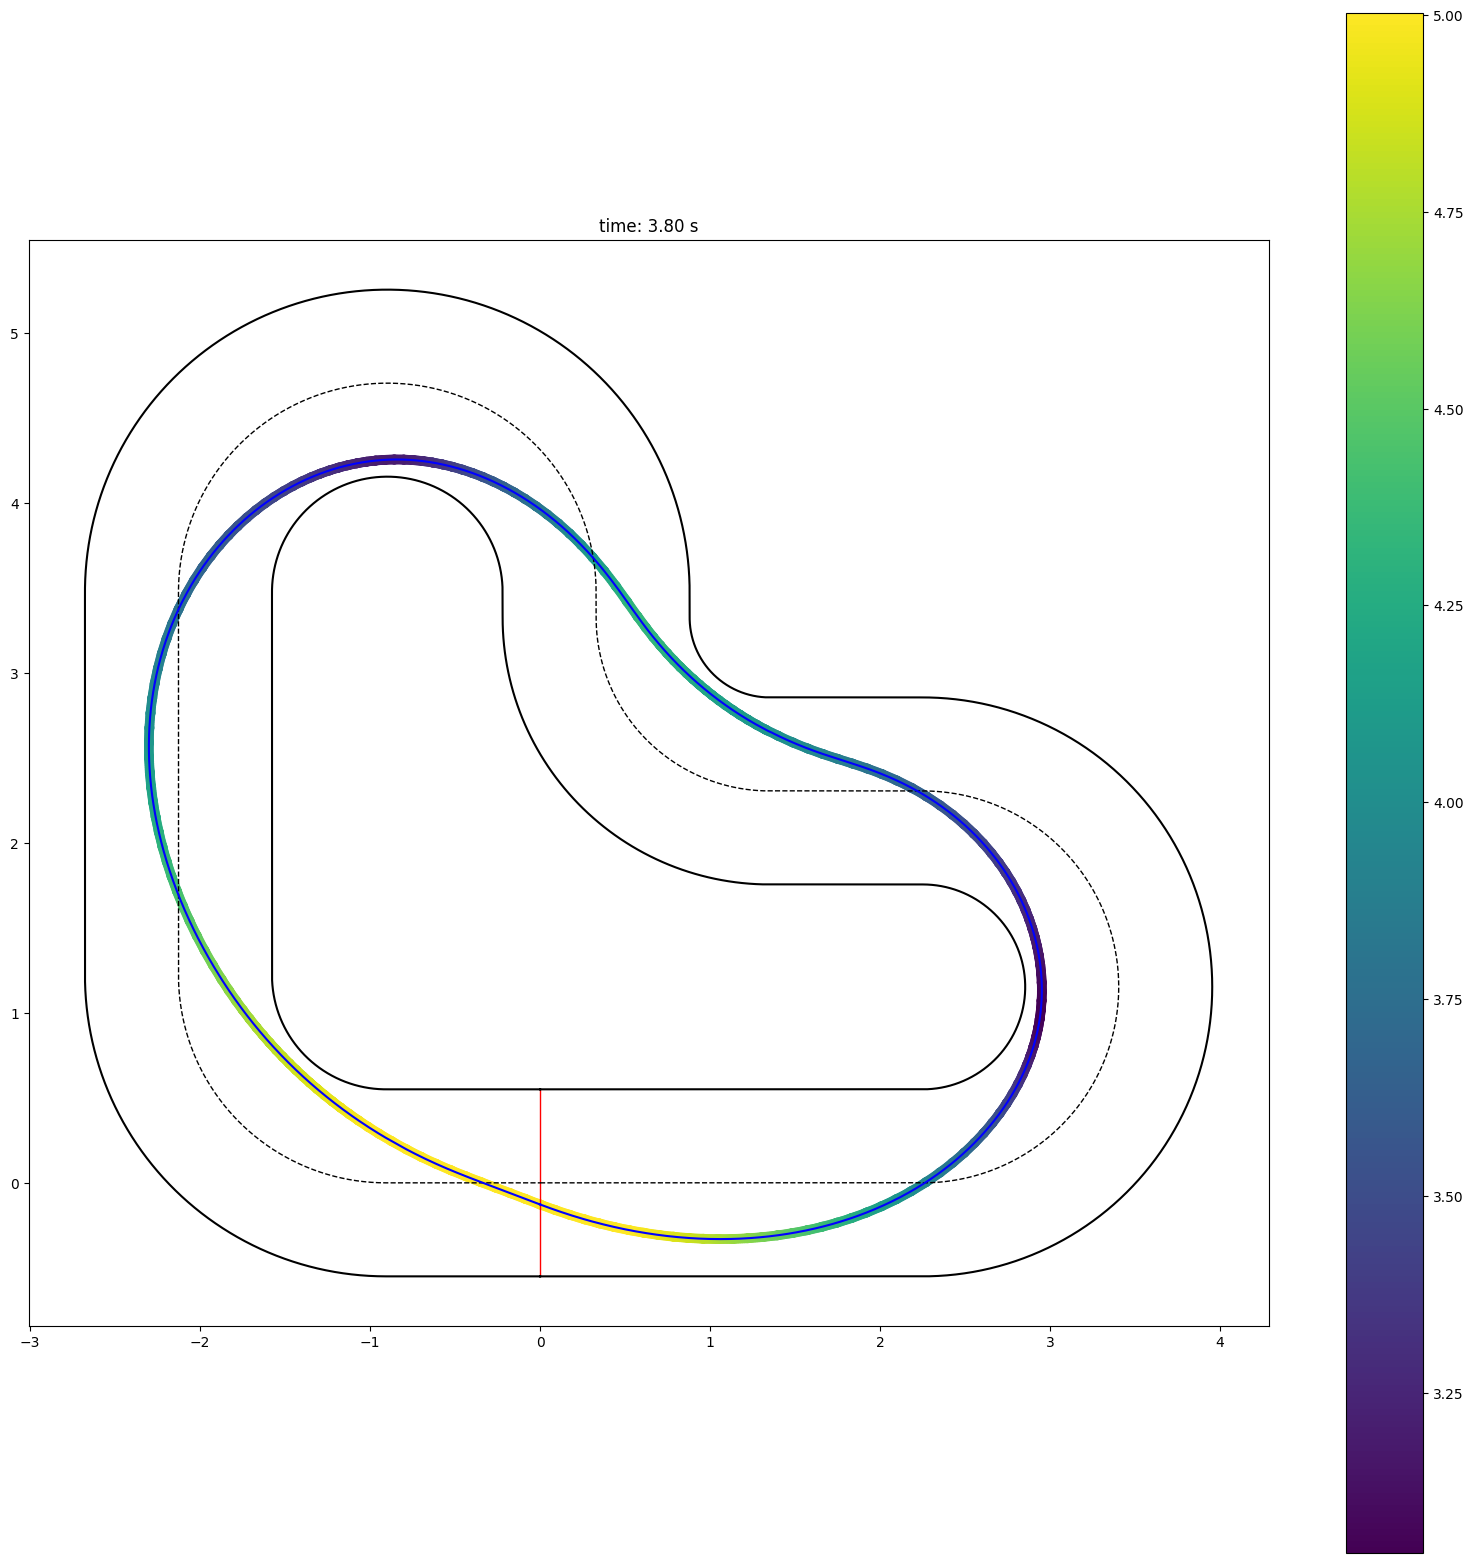

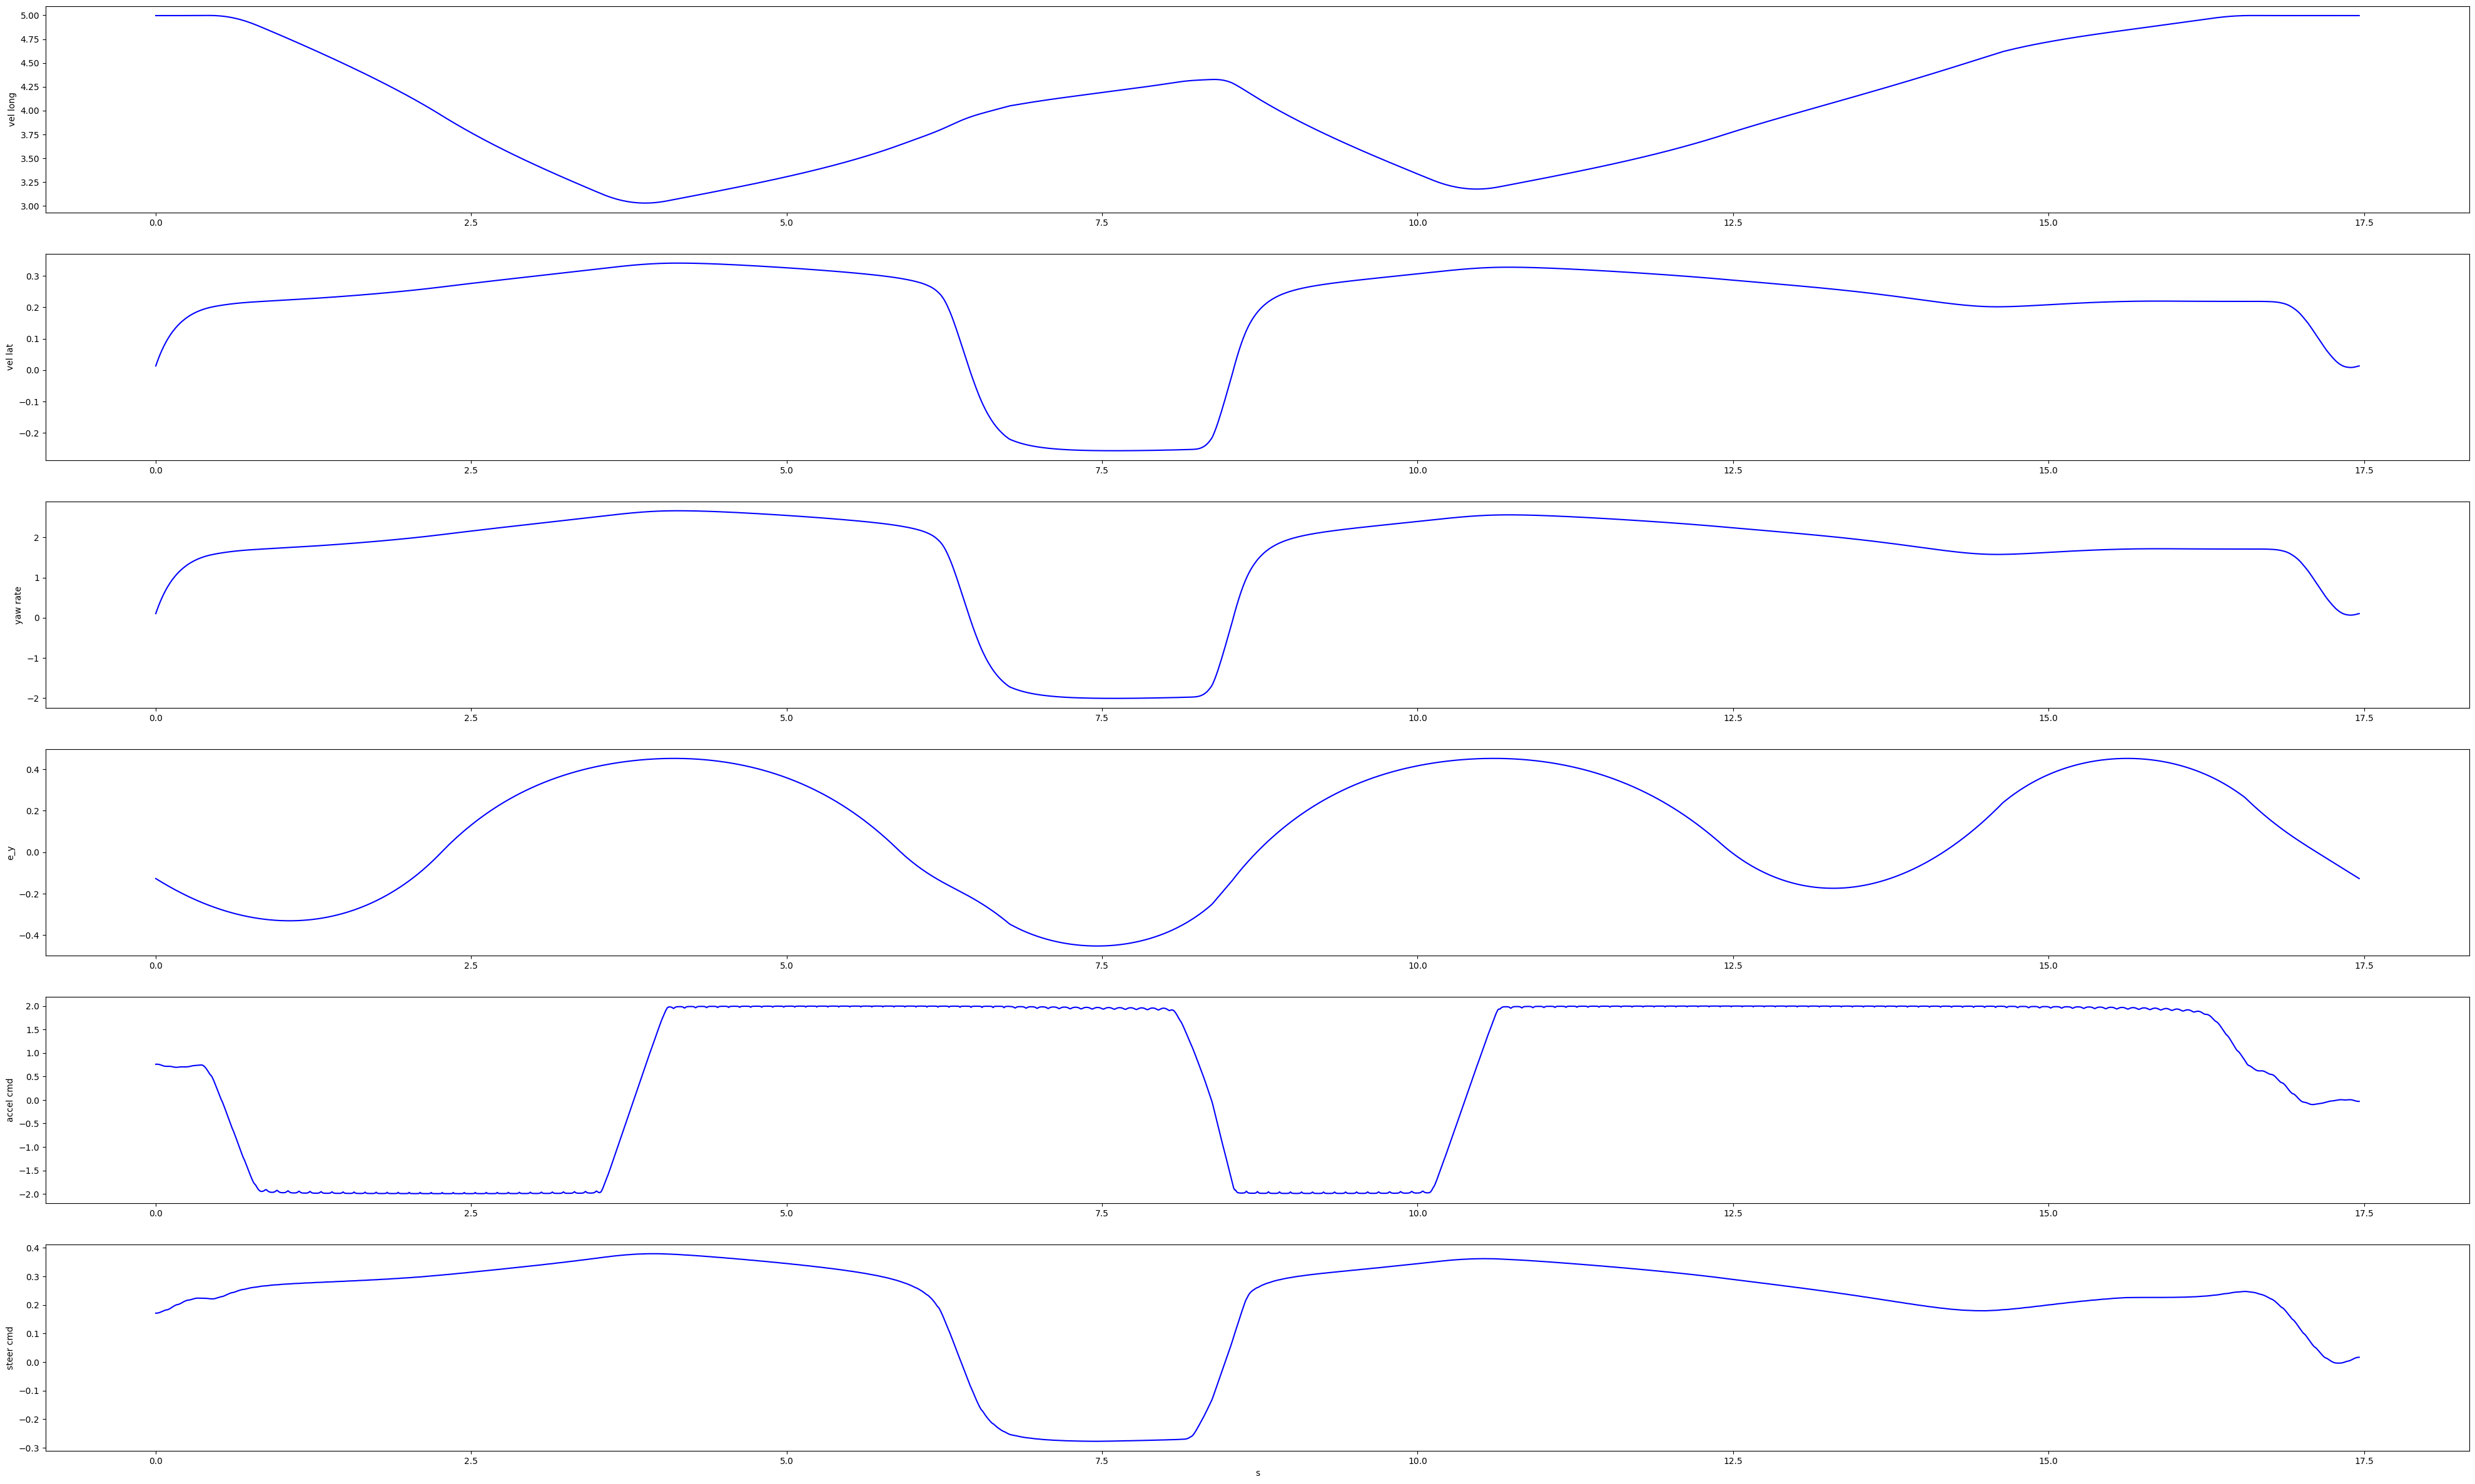

In [ ]:
from google.colab import files
import os
from mpclab_common.models.model_types import DynamicBicycleConfig
from mpclab_common.track import get_track

track_name = 'L_track_barc'
track_obj = get_track(track_name)

vehicle_config = DynamicBicycleConfig(wheel_dist_front=0.132,
                                    wheel_dist_rear=0.128,
                                    mass=2.258, #2.158,
                                    yaw_inertia=0.01771, #0.026188,
                                    drag_coefficient=0.0,
                                    tire_model='pacejka',
                                    wheel_friction=0.9, #0.96,
                                    pacejka_b_front=5.0, #0.99,
                                    pacejka_b_rear=575055782097995, #0.99,
                                    pacejka_c_front=2.28, #11.04,
                                    pacejka_c_rear=2.0524659447890445, #11.04,
                                    simple_slip=False)

VW = 0.195
track_tightening = VW/2

state_input_ub = VehicleState(p=ParametricPose(x_tran=1e9, e_psi=np.pi/2),
                                v=BodyLinearVelocity(v_long=5, v_tran=1),
                                w=BodyAngularVelocity(w_psi=10),
                                u=VehicleActuation(u_a=2.0, u_steer=0.436))
state_input_lb = VehicleState(p=ParametricPose(x_tran=-1e9, e_psi=-np.pi/2),
                                v=BodyLinearVelocity(v_long=0.1, v_tran=-1),
                                w=BodyAngularVelocity(w_psi=-10),
                                u=VehicleActuation(u_a=-2.0, u_steer=-0.436))
input_rate_ub = VehicleActuation(u_a=40, u_steer=4.5)
input_rate_lb = VehicleActuation(u_a=-40, u_steer=-4.5)
vehicle_constraints = {'xu_ub': state_input_ub, 'xu_lb': state_input_lb, 'du_ub': input_rate_ub, 'du_lb': input_rate_lb}

obj_num = 0
raceline_1, raceline_data = compute_raceline(track_obj, vehicle_config, vehicle_constraints,
                                                obj_num=obj_num,
                                                track_tightening=track_tightening,
                                                constant_width=True)
# raceline_2, _ = compute_raceline(track_name, vehicle_config, vehicle_constraints, raceline_to_avoid=raceline_data)

plot = True
save = True

if save:
    # save_dir = os.path.expanduser('~/barc_data/racelines')
    # if not os.path.exists(save_dir):
        # os.makedirs(save_dir)
    save_dir = ''

    # filename = track_name + '_raceline.npz'
    filename = 'raceline.npz'
    save_path = filename
    # save_path = os.path.join(save_dir, filename)
    print('Saving computed raceline to %s' % save_path)
    np.savez(save_path, **raceline_1)
    files.download(save_path)

    # filename = track_name + '_raceline_2.npz'
    # save_path = os.path.join(save_dir, filename)
    # print('Saving computed raceline to %s' % save_path)
    # np.savez(save_path, **raceline_2)

if plot:
    # plot_racelines(track_name, [raceline_1, raceline_2], ['b', 'r'])
    plot_racelines(track_obj, [raceline_1], ['b'])